In [1]:
from cryoS2Sdrop.analyze import *
from cryoS2Sdrop.deconvolution import tom_deconv_tomo
from skimage import exposure

PARENT_PATH = setup.PARENT_PATH

import matplotlib as mpl
from matplotlib.transforms import offset_copy
mpl.rc("image", cmap="gray")

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

def make_shell(inner_radius, outer_radius, tomo_shape):
    """
    Creates a (3D) shell with given inner_radius and delta_r width centered at the middle of the array.

    """

    length = min(tomo_shape)
    if length % 2 == 1:
        length = length - 1

    mask_shape = len(tomo_shape) * [length]
    _shell_mask = np.zeros(mask_shape)

    # only do positive quadrant first
    for z in range(0, outer_radius + 1):
        for y in range(0, outer_radius + 1):
            for x in range(0, outer_radius + 1):

                r = np.linalg.norm([z, y, x])

                if r >= inner_radius and r < outer_radius:
                    zidx = z + length // 2
                    yidx = y + length // 2
                    xidx = x + length // 2

                    _shell_mask[zidx, yidx, xidx] = 1

    aux = (
        np.rot90(_shell_mask, axes=(0, 1))
        + np.rot90(_shell_mask, 2, axes=(0, 1))
        + np.rot90(_shell_mask, 3, axes=(0, 1))
    )

    _shell_mask = _shell_mask + aux  # this is half the volume

    aux = np.rot90(
        _shell_mask, 2, axes=(1, 2)
    )  # rotate again 180º to get full volume

    aux2 = _shell_mask + aux

    if inner_radius == 0:
        vol = 4 / 3 * np.pi * outer_radius**3
        pct_diff = (vol - aux2.sum()) / vol
        if pct_diff > 0.1:
            print(pct_diff)
            raise ValueError("Sanity check for sphere volume not passed")

    # finally, fill the actual shape of the tomogram with the mask
    shell_mask = np.zeros(tomo_shape)
    shell_mask[
        (tomo_shape[0] - length) // 2 : (tomo_shape[0] + length) // 2,
        (tomo_shape[1] - length) // 2 : (tomo_shape[1] + length) // 2,
        (tomo_shape[2] - length) // 2 : (tomo_shape[2] + length) // 2,
    ] = aux2

    return shell_mask

def create_hiFreqMask(tomo_shape, fourier_tomo_shape):
    "Randomly mask high frequencies with a sphere"
    inner = 0
    shape_vol = np.array(tomo_shape).prod()
    low_r = (0.05 * 3/(4*np.pi) * shape_vol)**(1/3)
    high_r = (0.1 * 3/(4*np.pi) * shape_vol)**(1/3)
    outer = np.random.uniform(low_r, high_r)
    outer = int(np.round(outer))
    
    shell_mask = make_shell(inner, outer, tomo_shape)
    # up to this point we have a shell for the shifted (centered) full spectrum
    shell_mask = torch.tensor(shell_mask)
    # # make shell correspond to the unshifted spectrum
    # shell_mask = torch.fft.ifftshift(shell_mask)
    # # make it correspond to only real part of spectrum
    # shell_mask = shell_mask[..., 0 : fourier_tomo_shape[-1]]

    return shell_mask.float().numpy()

def create_Vmask(tomo_shape, volumetric_scale_factor):
    "Create volumetric blind spot random mask"
    downsampled_shape = np.array(tomo_shape) // volumetric_scale_factor
    downsampled_shape = tuple(downsampled_shape)

    bernoulli_Vmask = dropoutV(torch.ones(downsampled_shape)) * (
        1 - dropoutV.p
    )
    bernoulli_Vmask = bernoulli_Vmask.unsqueeze(0).unsqueeze(0)
    bernoulli_Vmask = upsample(bernoulli_Vmask)
    
    # adjust for uneven sizes on dimension 0
    diff0 = tomo_shape[0] - bernoulli_Vmask.shape[2]
    if (diff0 > 0) and (diff0 < volumetric_scale_factor):
        extra_row = bernoulli_Vmask[:, :, 0:diff0, ...]
        bernoulli_Vmask = torch.cat([extra_row, bernoulli_Vmask], dim=2)

    return bernoulli_Vmask.squeeze().numpy()

def _create_inversionMask(tomo_shape):
    tomo_shape = tuple(tomo_shape)
    bernoulli_Pmask = dropout(torch.ones(tomo_shape)) * (1 - dropout.p)
    bernoulli_Pmask = 2*bernoulli_Pmask - 1

    return bernoulli_Pmask.numpy()

def create_inversionMask(tomo_shape):
    downsampled_shape = np.array(tomo_shape) // 4
    downsampled_shape = tuple(downsampled_shape)
    
    bernoulli_Pmask = dropout(torch.ones(downsampled_shape)) * (1 - dropout.p)
    bernoulli_Pmask = bernoulli_Pmask.unsqueeze(0).unsqueeze(0)
    bernoulli_Pmask = upsample2(bernoulli_Pmask)
    
    bernoulli_Pmask = 2*bernoulli_Pmask - 1

    return bernoulli_Pmask.squeeze().numpy()

def get_powerSpectrum(fourier_data, scale_data=False):
    power_data = np.log(np.abs(fourier_data)**2)
    if scale_data:
        power_data = scale(power_data)
    else:
        pass
    return power_data

# Figure 2. Mask and ifft comparison

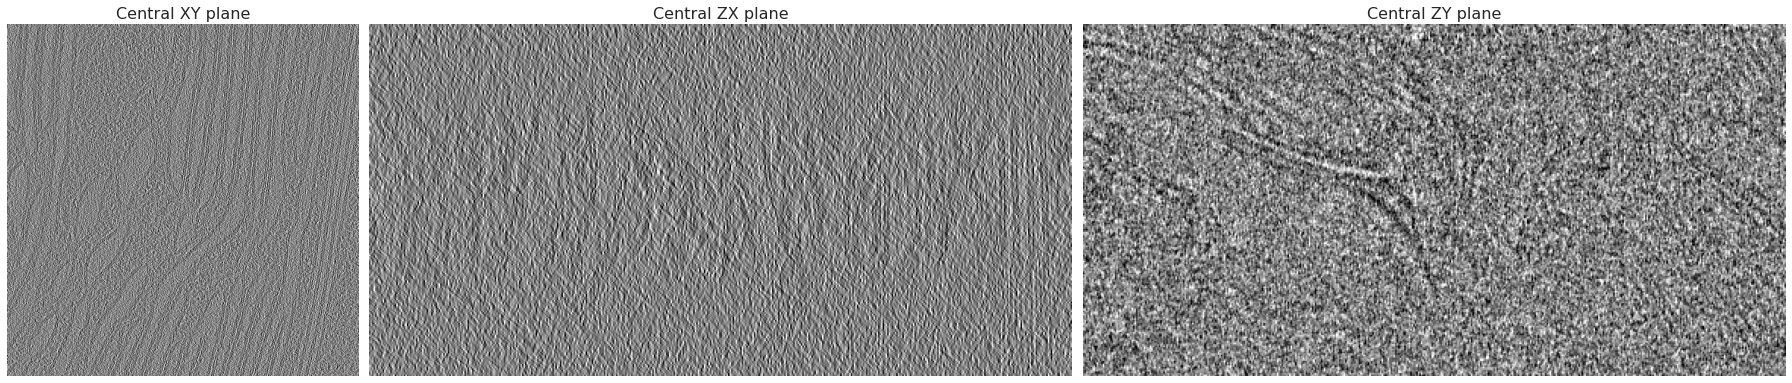

In [9]:
# tomo_name = "tomoPhantom_model14_noisyGaussPoissL"
# tomo_name = "shrec2021_model4_dummy"
tomo_name = "tomo02_dummy"

cet_path, gt_cet_path = parse_tomoPaths(tomo_name)
tomo_data, gt_tomo_data = read_array(cet_path), read_array(gt_cet_path)
# z, y, x = tomo_data.shape
# tomo_data, gt_tomo_data = tomo_data[z//4:3*z//4, z//4:3*y//4, z//4:3*x//4], gt_tomo_data[z//4:3*z//4, z//4:3*y//4, z//4:3*x//4] 

tomo_data = standardize(clip(tomo_data))

gt_tomo_data = standardize(clip(gt_tomo_data))

fourier_tomo = np.fft.fftshift(np.fft.fftn(tomo_data))
fourier_tomo_shape = np.array(fourier_tomo.shape)

tomo_shape = np.array(tomo_data.shape)
fig, ax = plot_centralSlices(tomo_data, set_axis_off=True)

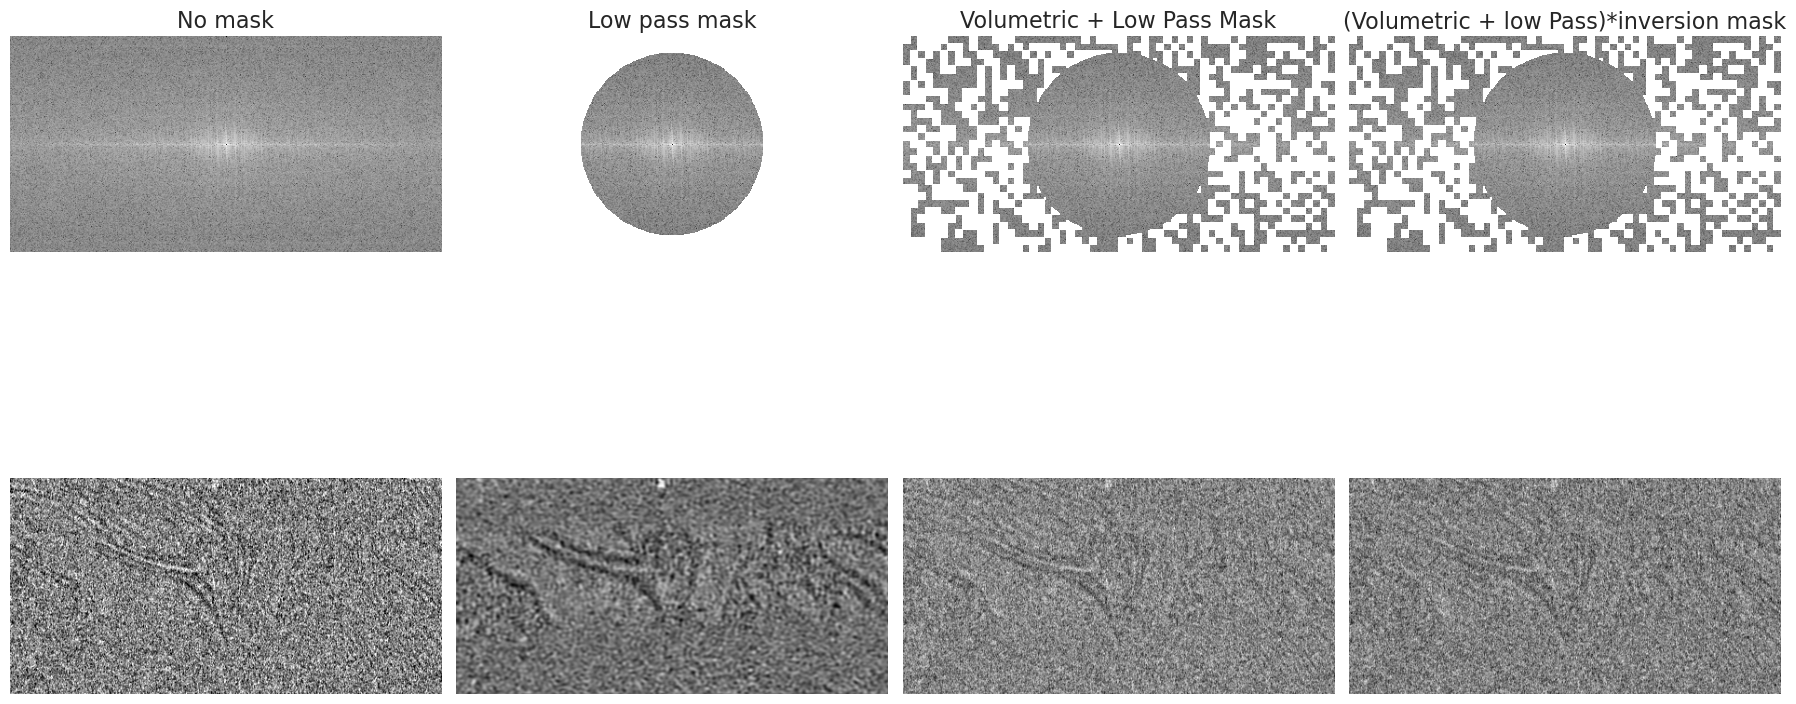

In [19]:
Vmask_pct = 0.5
volumetric_scale_factor = 8

dropoutV = torch.nn.Dropout(p=Vmask_pct)
upsample = torch.nn.Upsample(scale_factor=volumetric_scale_factor)

p = 0.1
dropout = torch.nn.Dropout(p)
upsample2 = torch.nn.Upsample(scale_factor=4)

fig, ax = plt.subplots(2, 4, figsize=(18, 9), dpi=100)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))

plt.tight_layout()

idx_central_slices = tomo_shape//2

ax_fourier = ax[0]
ax_real = ax[1]

i = 2
# Original
ax_fourier[0].imshow(np.take(get_powerSpectrum(fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[0].set_title("No mask", fontsize=16)
ax_real[0].imshow(np.take(tomo_data, idx_central_slices[i], axis=i))

# Create the masks
Vmask = create_Vmask(tomo_shape, volumetric_scale_factor)
lowPassMask = create_hiFreqMask(tomo_shape, fourier_tomo_shape)
invMask = create_inversionMask(tomo_shape)


# Masked tomo 1
masked1_fourier_tomo = fourier_tomo*lowPassMask

masked1_data = np.fft.ifftn(np.fft.ifftshift(masked1_fourier_tomo))
masked1_data = masked1_data.real

ax_fourier[1].imshow(np.take(get_powerSpectrum(masked1_fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[1].set_title("Low pass mask", fontsize=16)
ax_real[1].imshow(np.take(masked1_data, idx_central_slices[i], axis=i))

# Masked tomo 2
mask2 = Vmask+lowPassMask
mask2 = np.where(mask2>1, 1, mask2)

masked2_fourier_tomo = fourier_tomo*mask2

masked2_data = np.fft.ifftn(np.fft.ifftshift(masked2_fourier_tomo))
masked2_data = masked2_data.real

ax_fourier[2].imshow(np.take(get_powerSpectrum(masked2_fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[2].set_title("Volumetric + Low Pass Mask", fontsize=16)
ax_real[2].imshow(np.take(masked2_data, idx_central_slices[i], axis=i))

# Full mask
mask3 = Vmask+lowPassMask
mask3 = np.where(mask3>1, 1, mask3)
mask3 = invMask*mask3

masked3_fourier_tomo = fourier_tomo*mask3

masked3_data = np.fft.ifftn(np.fft.ifftshift(masked3_fourier_tomo))
masked3_data = masked3_data.real

ax_fourier[3].imshow(np.take(get_powerSpectrum(masked3_fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[3].set_title("(Volumetric + low Pass)*inversion mask", fontsize=16)
ax_real[3].imshow(np.take(masked3_data, idx_central_slices[i], axis=i))

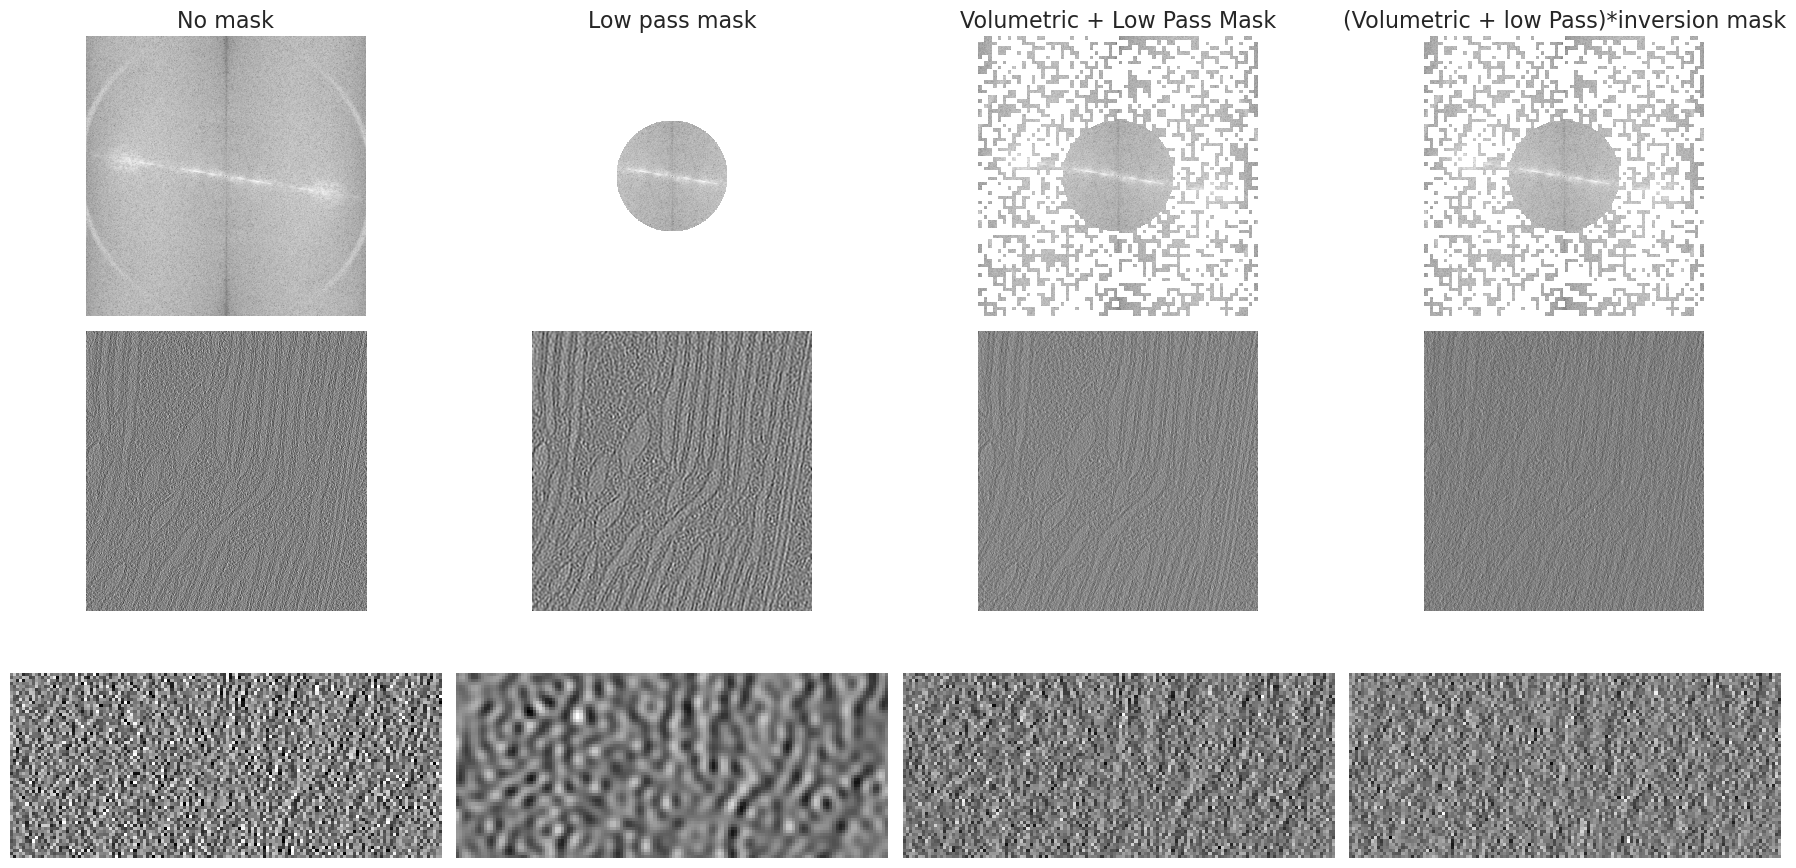

In [25]:
Vmask_pct = 0.5
volumetric_scale_factor = 8

dropoutV = torch.nn.Dropout(p=Vmask_pct)
upsample = torch.nn.Upsample(scale_factor=volumetric_scale_factor)

p = 0.2
dropout = torch.nn.Dropout(p)

fig, ax = plt.subplots(3, 4, figsize=(18, 9), dpi=100)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))

plt.tight_layout()

idx_central_slices = tomo_shape//2
Yval = 30
Xval = 70
Yzoom_min, Yzoom_max = idx_central_slices[1] - Yval, idx_central_slices[1] + Yval
Xzoom_min, Xzoom_max = idx_central_slices[2] - Xval, idx_central_slices[2] + Xval

ax_fourier = ax[0]
ax_real = ax[1]
ax_zoom = ax[2]

i = 0
# Original
ax_fourier[0].imshow(np.take(get_powerSpectrum(fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[0].set_title("No mask", fontsize=16)

aux_data = np.take(tomo_data, idx_central_slices[i], axis=i)
ax_real[0].imshow(aux_data)
ax_zoom[0].imshow(aux_data[Yzoom_min:Yzoom_max, Xzoom_min:Xzoom_max])

# Create the masks
Vmask = create_Vmask(tomo_shape, volumetric_scale_factor)
lowPassMask = create_hiFreqMask(tomo_shape, fourier_tomo_shape)
invMask = _create_inversionMask(tomo_shape)


# Masked tomo 1
masked1_fourier_tomo = fourier_tomo*lowPassMask

masked1_data = np.fft.ifftn(np.fft.ifftshift(masked1_fourier_tomo))
masked1_data = masked1_data.real

ax_fourier[1].imshow(np.take(get_powerSpectrum(masked1_fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[1].set_title("Low pass mask", fontsize=16)

aux_data = np.take(masked1_data, idx_central_slices[i], axis=i)
ax_real[1].imshow(aux_data)
ax_zoom[1].imshow(aux_data[Yzoom_min:Yzoom_max, Xzoom_min:Xzoom_max])

# Masked tomo 2
mask2 = Vmask+lowPassMask
mask2 = np.where(mask2>1, 1, mask2)

masked2_fourier_tomo = fourier_tomo*mask2

masked2_data = np.fft.ifftn(np.fft.ifftshift(masked2_fourier_tomo))
masked2_data = masked2_data.real

ax_fourier[2].imshow(np.take(get_powerSpectrum(masked2_fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[2].set_title("Volumetric + Low Pass Mask", fontsize=16)

aux_data = np.take(masked2_data, idx_central_slices[i], axis=i)
ax_real[2].imshow(aux_data)
ax_zoom[2].imshow(aux_data[Yzoom_min:Yzoom_max, Xzoom_min:Xzoom_max])

# Full mask
mask3 = Vmask+lowPassMask
mask3 = np.where(mask3>1, 1, mask3)
mask3 = invMask*mask3

masked3_fourier_tomo = fourier_tomo*mask3

masked3_data = np.fft.ifftn(np.fft.ifftshift(masked3_fourier_tomo))
masked3_data = masked3_data.real

ax_fourier[3].imshow(np.take(get_powerSpectrum(masked3_fourier_tomo), idx_central_slices[i], axis=i))
ax_fourier[3].set_title("(Volumetric + low Pass)*inversion mask", fontsize=16)

aux_data = np.take(masked3_data, idx_central_slices[i], axis=i)
ax_real[3].imshow(aux_data)
ax_zoom[3].imshow(aux_data[Yzoom_min:Yzoom_max, Xzoom_min:Xzoom_max])

# Figure 3. Denoising comparison between datasets and methods

## Helper functions

In [8]:
def paths2dataDict(pathDict):
    dataDict = []
    
    # as of 20.12 we used a different clipping for shrec, also gt_data needs to be processed differently
    if 'shrec' in pathDict['raw_path']:
        for x in tqdm(pathDict.keys()):
            if pathDict[x] is not None and x!='gt_path':
                val = clip(read_array(pathDict[x]), low=0.0005, high=0.9995)
                val = scale(standardize(val))
            elif pathDict[x] is not None and x=='gt_path':
                val = -1*read_array(pathDict[x])
                val = val - val.min()
                val = clip(val, low=0.0005, high=0.9995)
                val = scale(standardize(val))
            else:
                val = None
            
            dataDict.append(val)
                    
    else:
        for x in tqdm(pathDict.keys()):
            if pathDict[x] is not None:
                val = clip(read_array(pathDict[x]), low=0.005, high=0.995)
                val = scale(standardize(val))
            else:
                val = None  
                
            dataDict.append(val)
        
    dataDict = dict(zip(pathDict.keys(), dataDict))    
    
    
    return dataDict

# tomoPhantom
def get_tomoPhantom_dataDict(model_no=8):
    raw_path = '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model%i_noisyGaussPoissVL_Perlin.mrc' %model_no
    deconv_path = None
    cryoCARE_path = None
    S2Sd_path = '/home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model%i_noisyGaussPoissVL_Perlin/structuredNoise_comparison/version_1/tomoPhantom_model%i_noisyGaussPoissVL_Perlin_s2sDenoised.mrc' %(model_no, model_no)
    F2Fd_path = '/home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomoPhantom_model%i_noisyGaussPoissVL_Perlin/structuredNoise_comparison/version_0/tomoPhantom_model%i_noisyGaussPoissVL_Perlin_s2sDenoised.mrc' %(model_no, model_no)
    isoNet_path = None
    gt_path = '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model%i.mrc' %model_no
    
    pathDict = {
        'raw_path':raw_path,
        'deconv_path':deconv_path,
        'cryoCARE_path':cryoCARE_path,
        'S2Sd_path':S2Sd_path,
        'F2Fd_path':F2Fd_path,
        'isoNet_path':isoNet_path,
        'gt_path':gt_path,
    }
    
    return paths2dataDict(pathDict)

# SHREC 21
def get_shrec_dataDict(model_no=2):
    raw_path = '/home/ubuntu/Thesis/data/shrec2021/model_%i/reconstruction.mrc' %model_no
    deconv_path = '/home/ubuntu/Thesis/data/isoNet/SHREC_dataset/SHREC_tomos_deconv/model_%i.mrc' %model_no
    if model_no==2:
        cryoCARE_path = '/home/ubuntu/Thesis/data/shrec2021/model_%i/cryoCARE_reconstruction.mrc' %model_no
    else:
        cryoCARE_path = None
        
    S2Sd_path = '/home/ubuntu/Thesis/data/S2SDenoising/model_logs/shrec2021_model_%i/samplingStrategy_comparison/version_1/reconstruction_s2sDenoised.mrc' %model_no
    F2Fd_path = '/home/ubuntu/Thesis/data/S2SDenoising/model_logs/shrec2021_model_%i/samplingStrategy_comparison/version_0/reconstruction_s2sDenoised.mrc' %model_no
    isoNet_path = '/home/ubuntu/Thesis/data/isoNet/SHREC_dataset/SHREC_corrected/model_%i_corrected.mrc' %model_no
    gt_path = '/home/ubuntu/Thesis/data/shrec2021/model_%i/grandmodel.mrc' %model_no
    
    pathDict = {
        'raw_path':raw_path,
        'deconv_path':deconv_path,
        'cryoCARE_path':cryoCARE_path,
        'S2Sd_path':S2Sd_path,
        'F2Fd_path':F2Fd_path,
        'isoNet_path':isoNet_path,
        'gt_path':gt_path,
    }
    
    return paths2dataDict(pathDict)

# spinach
def get_spinach_dataDict(tomo_no=2):
    raw_path = '/home/ubuntu/Thesis/data/raw_cryo-ET/tomo%02i.mrc' %tomo_no
    deconv_path = '/home/ubuntu/Thesis/data/isoNet/RAW_dataset/RAW_tomos_deconv/tomo%02i.mrc' %tomo_no
    cryoCARE_path = '/home/ubuntu/Thesis/data/nnUnet/nifti_files/tomo%02i_bin4_denoised_0000.nii.gz' %tomo_no
    S2Sd_path = None
    F2Fd_path = '/home/ubuntu/Thesis/data/S2SDenoising/model_logs/tomo%02i/raw_denoising/version_0/tomo%02i_s2sDenoised.mrc' %(tomo_no, tomo_no)
    isoNet_path = '/home/ubuntu/Thesis/data/isoNet/RAW_dataset/RAW_corrected/tomo%02i_corrected.mrc' %tomo_no
    gt_path = None
    
    pathDict = {
        'raw_path':raw_path,
        'deconv_path':deconv_path,
        'cryoCARE_path':cryoCARE_path,
        'S2Sd_path':S2Sd_path,
        'F2Fd_path':F2Fd_path,
        'isoNet_path':isoNet_path,
        'gt_path':gt_path,
    }
    
    return paths2dataDict(pathDict)

In [9]:
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

def imshow_centralSlice(dataDict, key, axes, ax_index, axis, gt_key):
    aux_data = dataDict[key]
    aux_gt_data = dataDict[gt_key]
    
    if aux_data is not None:
        _ssim = ssim(torch.tensor(aux_gt_data).unsqueeze(0).unsqueeze(0),
                     torch.tensor(aux_data).unsqueeze(0).unsqueeze(0), 
                     data_range=1)

        _psnr = peak_signal_noise_ratio(torch.tensor(aux_gt_data).unsqueeze(0).unsqueeze(0),
                     torch.tensor(aux_data).unsqueeze(0).unsqueeze(0), 
                     data_range=1)
        
        idx_central_slices = np.array(aux_data.shape)//2
        aux_data = np.take(aux_data, idx_central_slices[axis], axis=axis)
        aux_gt_data = np.take(aux_gt_data, idx_central_slices[axis], axis=axis)
        
        a = axes[ax_index].imshow(aux_data)
        # a.axes.get_yaxis().set_visible(False)
        # a.axes.get_xaxis().set_visible(False)

        axes[ax_index].text(0.0125, 0.02, 'SSIM:%.02f' %float(_ssim), transform=axes[ax_index].transAxes, size=17, color='white')
        axes[ax_index].text(0.5, 0.02, 'PSNR:%.02f' %float(_psnr), transform=axes[ax_index].transAxes, size=17, color='white')
        
    else:
        a = None
    
    return a

## Set 1

In [10]:
tomoPhantom_dataDict = get_tomoPhantom_dataDict()
shrec_dataDict = get_shrec_dataDict()
spinach_dataDict = get_spinach_dataDict()

100%|████████████████████████████████████████| 7/7 [12:59<00:00, 111.34s/it]


100%|█████████████████████████████████████████| 6/6 [06:53<00:00, 68.87s/it]


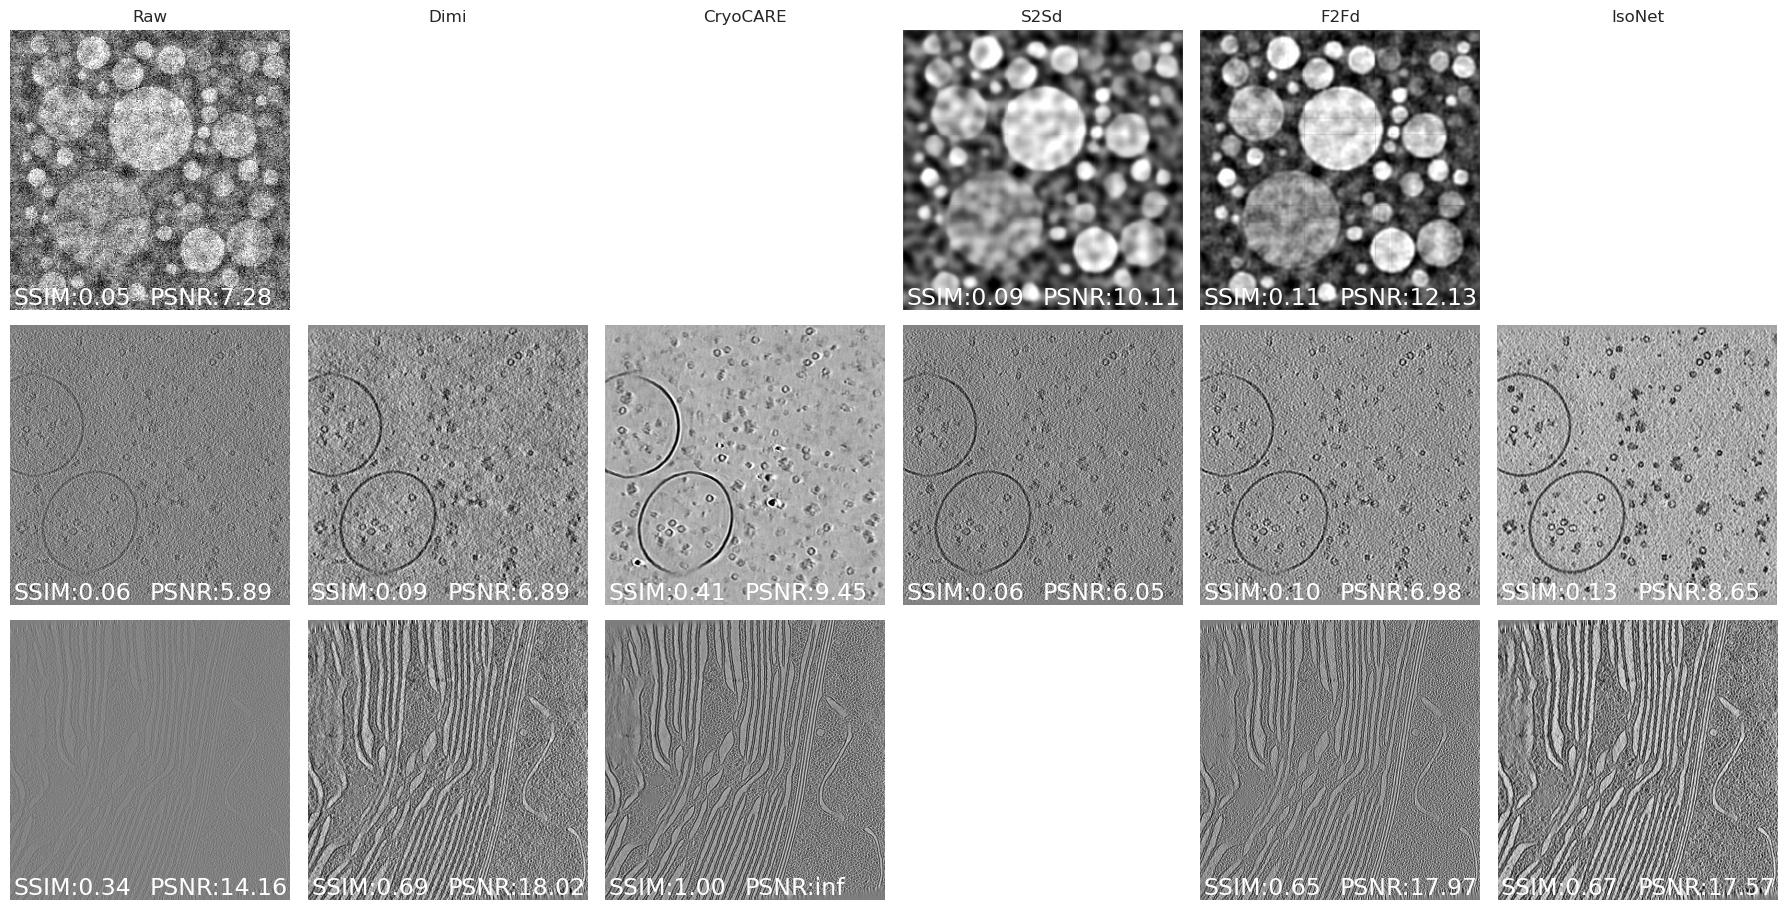

In [11]:
used_keys = ['raw_path', 'deconv_path', 'cryoCARE_path', 'S2Sd_path', 'F2Fd_path', 'isoNet_path']

cols = ['Raw', 'Dimi', 'CryoCARE', 'S2Sd', 'F2Fd', 'IsoNet']
rows = ['TomoPhantom', 'SHREC', 'Spinach']

fig, ax = plt.subplots(3, len(used_keys), figsize=(18, 9), dpi=100)
# add_headers(fig, col_headers=cols, row_headers=rows)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
plt.tight_layout()

for axi, col in zip(ax[0], cols):
    axi.set_title(col)

tomoPhantom_ax = ax[0]
shrec_ax = ax[1]
spinach_ax = ax[2]

i = 0
for idx, key in enumerate(tqdm(used_keys)):
    imshow_centralSlice(tomoPhantom_dataDict, key, tomoPhantom_ax, idx, 0, 'gt_path')
    imshow_centralSlice(shrec_dataDict, key, shrec_ax, idx, 0, 'gt_path')
    imshow_centralSlice(spinach_dataDict, key, spinach_ax, idx, 0, 'cryoCARE_path')

## Set 2

In [6]:
tomoPhantom_dataDict = get_tomoPhantom_dataDict(14)
shrec_dataDict = get_shrec_dataDict(2)
spinach_dataDict = get_spinach_dataDict(17)

100%|█████████████████████████████████████████| 7/7 [02:06<00:00, 18.08s/it]


In [ ]:
used_keys = ['raw_path', 'deconv_path', 'cryoCARE_path', 'S2Sd_path', 'F2Fd_path', 'isoNet_path']

cols = ['Raw', 'Dimi', 'CryoCARE', 'S2Sd', 'F2Fd', 'IsoNet']
rows = ['TomoPhantom', 'SHREC', 'Spinach']

fig, ax = plt.subplots(3, len(used_keys), figsize=(18, 9), dpi=100)
# add_headers(fig, col_headers=cols, row_headers=rows)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
plt.tight_layout()

for axi, col in zip(ax[0], cols):
    axi.set_title(col)

tomoPhantom_ax = ax[0]
shrec_ax = ax[1]
spinach_ax = ax[2]

i = 0
for idx, key in enumerate(tqdm(used_keys)):
    imshow_centralSlice(tomoPhantom_dataDict, key, tomoPhantom_ax, idx, 0, 'gt_path')
    imshow_centralSlice(shrec_dataDict, key, shrec_ax, idx, 0, 'gt_path')
    imshow_centralSlice(spinach_dataDict, key, spinach_ax, idx, 0, 'cryoCARE_path')

100%|█████████████████████████████████████████| 6/6 [04:38<00:00, 46.48s/it]
